In [ ]:
# Download libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 6.4 MB/s 
     |████████████████████████████████| 112 kB 63.5 MB/s 
     |████████████████████████████████| 19.1 MB 44.9 MB/s 
     |████████████████████████████████| 21.0 MB 17.7 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |██████████████████████████████▎ | 834.1 MB 62.3 MB/s eta 0:00:01tcmalloc: large alloc 1147494400 bytes == 0x3182000 @  0x7fa898e29615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 1.8 kB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |██████████████████

In [ ]:
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2022-07-11 12:37:09--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-11 12:37:09 ERROR 404: Not Found.

tar (child): testSetPlaces205_resize.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
import pandas as pd

df = pd.read_csv('/content/files.csv')
train_files = df.iloc[:5000, 0].values
test_files = df.iloc[5000:6000, 0].values

In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 5,000 images
os.makedirs('images/val/class/', exist_ok=True)   # 1,000 images

for i in range(5000):
  os.rename(train_files[i], 'images/train/class/img' + str(i) + '.jpg')

for i in range(1000):
  os.rename(test_files[i], 'images/val/class/img' + str(i) + '.jpg')

In [ ]:
!wget -x --load-cookies kaggle.com_cookies.txt "https://www.kaggle.com/datasets/mittalshubham/images256/download" -O data.zip
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: w/wheat_field/gsun_c204d885258b2ee2453589fb0d3cbe1d.jpg  
  inflating: w/wheat_field/gsun_c26440cdb74f6a63fd9eecd3bac0dfa0.jpg  
  inflating: w/wheat_field/gsun_c29ce9344d525ee85cb7b39170a0553f.jpg  
  inflating: w/wheat_field/gsun_c2a9244315f10218964efa2515c8e37c.jpg  
  inflating: w/wheat_field/gsun_c2e7c009d84952e8661ed4abc49e17e9.jpg  
  inflating: w/wheat_field/gsun_c31d069d302f7e24b713775260d21fa0.jpg  
  inflating: w/wheat_field/gsun_c31f20d4b97c91c8d03559d73ef65f5b.jpg  
  inflating: w/wheat_field/gsun_c32b87fc1c048026e51c23b0172fd8ac.jpg  
  inflating: w/wheat_field/gsun_c34210f215f1cde71109588b1c8616af.jpg  
  inflating: w/wheat_field/gsun_c343c694301c7ad37d9c13c17046513a.jpg  
  inflating: w/wheat_field/gsun_c3c01c68fb7f367ee80eed523abcef4a.jpg  
  inflating: w/wheat_field/gsun_c3c5502afb5a69542e85bf1cf203c632.jpg  
  inflating: w/wheat_field/gsun_c3c78553d816758a90a820e41f2a54b6.jpg  
  inflating: w/wheat_field

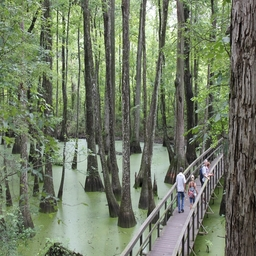

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='/content/images/val/class/img0.jpg'))

In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [ ]:
model = ColorizationNet()

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 10 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 10 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
# Train model
for epoch in range(epochs+1):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    if epoch%5 == 0:
      losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/79]	Time 1.379 (1.379)	Data 1.290 (1.290)	Loss 0.0031 (0.0031)	
Epoch: [0][10/79]	Time 1.303 (1.374)	Data 1.235 (1.303)	Loss 0.0042 (0.0032)	
Epoch: [0][20/79]	Time 1.333 (1.368)	Data 1.264 (1.298)	Loss 0.0026 (0.0032)	
Epoch: [0][30/79]	Time 1.324 (1.364)	Data 1.250 (1.294)	Loss 0.0036 (0.0032)	
Epoch: [0][40/79]	Time 1.332 (1.360)	Data 1.263 (1.290)	Loss 0.0032 (0.0032)	
Epoch: [0][50/79]	Time 1.321 (1.359)	Data 1.252 (1.290)	Loss 0.0029 (0.0032)	
Epoch: [0][60/79]	Time 1.356 (1.360)	Data 1.287 (1.290)	Loss 0.0026 (0.0032)	
Epoch: [0][70/79]	Time 1.323 (1.361)	Data 1.254 (1.292)	Loss 0.0023 (0.0031)	
Finished training epoch 0
Validate: [0/16]	Time 1.648 (1.648)	Loss 0.0039 (0.0039)	
Validate: [10/16]	Time 1.342 (1.344)	Loss 0.0039 (0.0037)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/79]	Time 1.404 (1.404)	Data 1.316 (1.316)	Loss 0.0030 (0.0030)	
Epoch: [1][10/79]	Time 1.375 (1.369)	Data 1.306 (1.298)	Loss 0.0029 (0.0032)	
Epoch:

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 40 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Validate: [0/16]	Time 1.653 (1.653)	Loss 0.0039 (0.0039)	
Validate: [10/16]	Time 1.325 (1.360)	Loss 0.0036 (0.0037)	
Finished validation.
Starting training epoch 16
Epoch: [16][0/79]	Time 1.385 (1.385)	Data 1.298 (1.298)	Loss 0.0034 (0.0034)	
Epoch: [16][10/79]	Time 1.398 (1.363)	Data 1.329 (1.293)	Loss 0.0029 (0.0032)	
Epoch: [16][20/79]	Time 1.360 (1.362)	Data 1.291 (1.293)	Loss 0.0031 (0.0031)	
Epoch: [16][30/79]	Time 1.380 (1.362)	Data 1.312 (1.293)	Loss 0.0027 (0.0031)	
Epoch: [16][40/79]	Time 1.343 (1.361)	Data 1.274 (1.293)	Loss 0.0031 (0.0031)	
Epoch: [16][50/79]	Time 1.374 (1.364)	Data 1.306 (1.295)	Loss 0.0022 (0.0031)	
Epoch: [16][60/79]	Time 1.359 (1.365)	Data 1.291 (1.296)	Loss 0.0027 (0.0031)	
Epoch: [16][70/79]	Time 1.364 (1.364)	Data 1.295 (1.295)	Loss 0.0024 (0.0031)	
Finished training epoch 16
Starting training epoch 17
Epoch: [17][0/79]	Time 1.377 (1.377)	Data 1.309 (1.309)	Loss 0.0033 (0.0033)	
Epoch: [17][10/79]	Time 1.351 (1.363)	Data 1.283 (1.294)	Loss 0.0025 (0.

<Figure size 432x288 with 0 Axes>

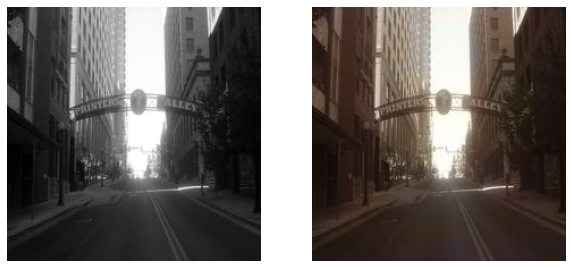

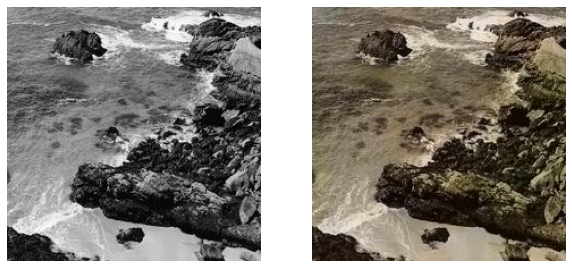

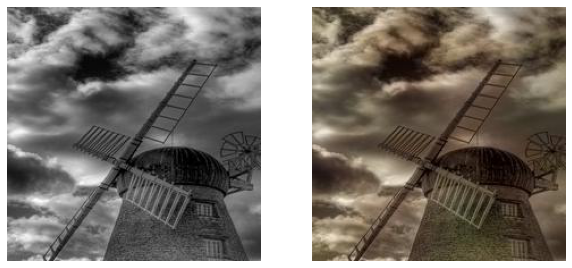

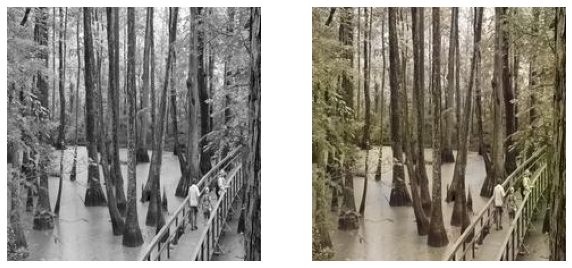

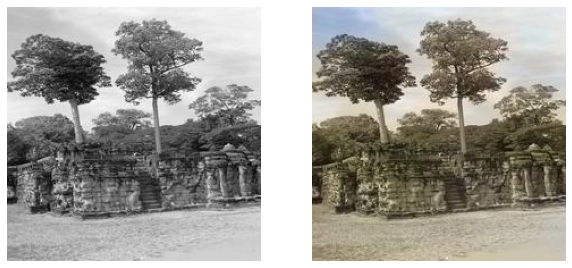

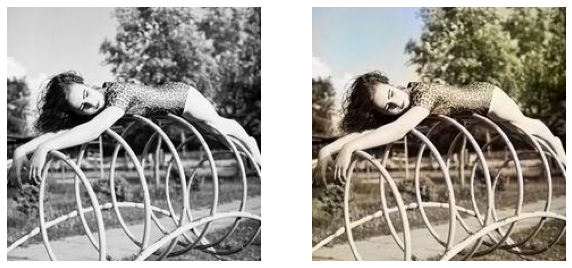

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-9-epoch-50.jpg', 'outputs/gray/img-9-epoch-50.jpg'),
               ('outputs/color/img-5-epoch-50.jpg', 'outputs/gray/img-5-epoch-50.jpg'),
               ('outputs/color/img-6-epoch-50.jpg', 'outputs/gray/img-6-epoch-50.jpg'),
               ('outputs/color/img-0-epoch-50.jpg', 'outputs/gray/img-0-epoch-50.jpg'),
               ('outputs/color/img-7-epoch-50.jpg', 'outputs/gray/img-7-epoch-50.jpg'),
               ('outputs/color/img-1-epoch-50.jpg', 'outputs/gray/img-1-epoch-50.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(10, 10)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()